In [1]:
########start

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse

In [13]:
data_path = "/data/users2/nshor/Multiband_with_MEG/sub-01/meg/"
filename = "sub-01_task-RDR_run-37_meg.fif"

raw = mne.io.read_raw_fif(data_path + filename)  # already has an average reference



Opening raw data file /data/users2/nshor/Multiband_with_MEG/sub-01/meg/sub-01_task-RDR_run-37_meg.fif...
    Range : 18662 ... 307078 =     18.662 ...   307.078 secs
Ready.


In [14]:
import os
import mne

directory = "/data/users2/nshor/Multiband_with_MEG/sub-01/meg/"
filename = "sub-01_task-RDR_run-37_meg.fif"

# Define the file path
file_path = os.path.join(directory, filename)

# Load raw data
raw = mne.io.read_raw_fif(file_path)

# Perform additional preprocessing as needed: artifact removal, downsampling, etc.


Opening raw data file /data/users2/nshor/Multiband_with_MEG/sub-01/meg/sub-01_task-RDR_run-37_meg.fif...
    Range : 18662 ... 307078 =     18.662 ...   307.078 secs
Ready.


In [15]:
channels_to_remove = ['IASX-', 'IAS_DY', 'STI005', 'STI008', 'IASY-', 'IAS_DX', 'STI007', 'SYS201', 'IAS_X', 'BIO001', 'IASY+', 'IAS_Y', 'STI002', 'STI003', 'IASX+', 'IASZ+', 'STI006', 'STI101', 'STI004', 'IAS_Z', 'STI001', 'IASZ-']

raw = raw.pick_channels(ch_names=[ch for ch in raw.ch_names if ch not in channels_to_remove])


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [16]:
# Specify the available channels in the picks parameter
#picks = mne.pick_types(raw.info, meg=False, eeg=False, stim=True)
picks = mne.pick_types(raw.info, meg=True, eeg=True, stim=True)  # Adjust the channel types as per your data

stim_channel = raw.info["ch_names"][picks[0]]  # Extract the stim channel name

events = mne.find_events(raw, stim_channel=stim_channel)
if len(events) > 0:
    event_id = dict(aud_l=1)  # event trigger and conditions
    tmin = -0.2  # start of each epoch (200ms before the trigger)
    tmax = 0.5  # end of each epoch (500ms after the trigger)
    raw.info["bads"] = ["MEG 2443", "EEG 053"]
    baseline = (None, 0)  # means from the first instant to t = 0
    reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

    epochs = mne.Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        proj=True,
        picks=("meg", "eog"),
        baseline=baseline,
        reject=reject,
    )
else:
    print("No events found. Cannot create epochs.")



No events found. Cannot create epochs.


In [17]:
# Compute covariance matrix for resting-state analysis
noise_cov = mne.compute_raw_covariance(raw)

Using up to 1442 segments
Number of samples used : 288400
[done]


Computing rank from covariance with rank=None
    Using tolerance 8.3e-14 (2.2e-16 eps * 102 dim * 3.7  max singular value)
    Estimated rank (mag): 70
Found multiple SSS records. Using the first.
    MAG: rank 70 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 6e-13 (2.2e-16 eps * 204 dim * 13  max singular value)
    Estimated rank (grad): 70
Found multiple SSS records. Using the first.
    GRAD: rank 70 computed from 204 data channels with 0 projectors


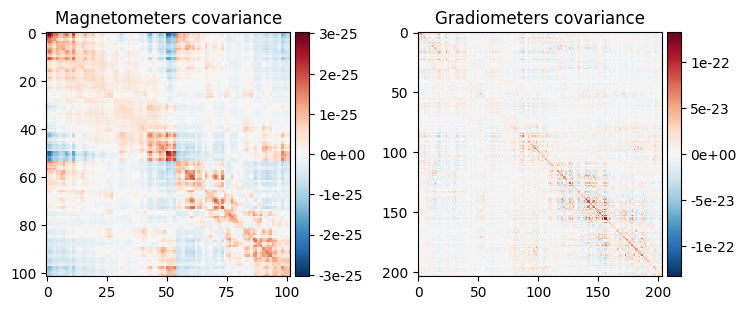

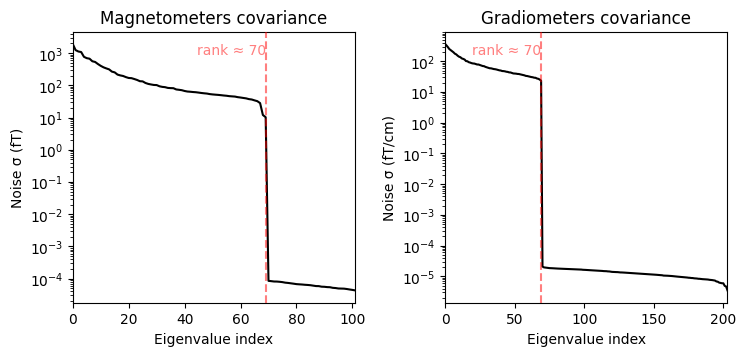

In [18]:
# Plot covariance matrix
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)


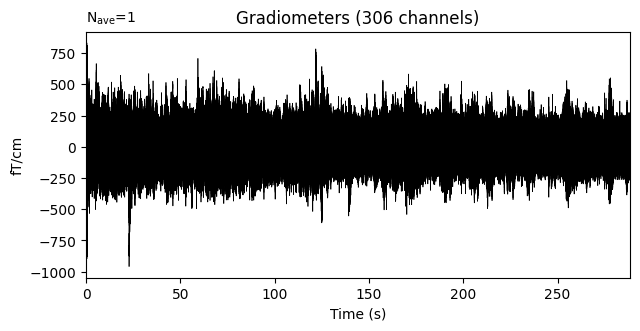

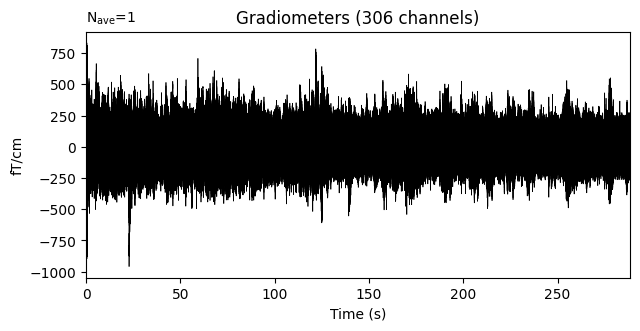

In [19]:
import mne

# Set the directory and filename
#directory = "/data/users2/nshor/Multiband_with_MEG/sub-01/meg/"
#filename = "sub-01_task-RDR_run-37_meg.fif"

# Load the raw data
#raw = mne.io.read_raw_fif(directory + filename, preload=True)

# Create an info object with the necessary information
info = mne.create_info(ch_names=raw.info['ch_names'], sfreq=raw.info['sfreq'], ch_types='grad')

# Convert the raw data to an Evoked object
evoked = mne.EvokedArray(data=raw.get_data(), info=info)

# Plot the evoked response
evoked.plot(time_unit="s")


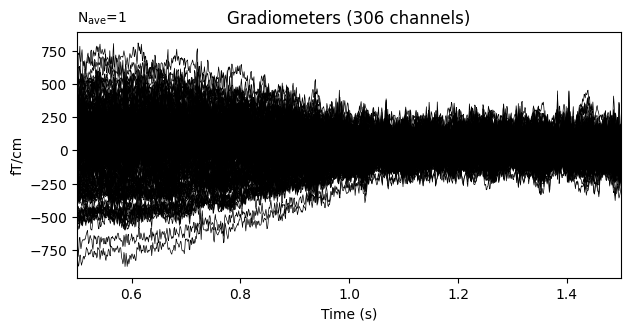

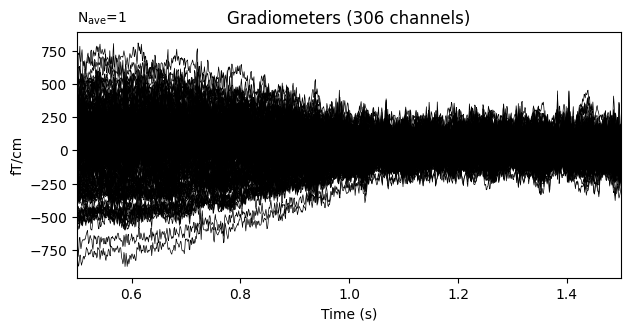

In [20]:
start_time = 0.5  # Start time in seconds
end_time = 1.5  # End time in seconds
evoked_crop = evoked.crop(tmin=start_time, tmax=end_time)
evoked_crop.plot()


In [22]:
evoked.info

<Info | 7 non-empty values
 bads: []
 ch_names: MEG0111, MEG0112, MEG0113, MEG0121, MEG0122, MEG0123, MEG0131, ...
 chs: 306 Gradiometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 306
 projs: []
 sfreq: 1000.0 Hz
>

In [23]:
common_channels = list(set(evoked.ch_names) & set(noise_cov.ch_names))
noise_cov = noise_cov.pick_channels(common_channels)


/tmp/ipykernel_543810/2861882760.py:2: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  noise_cov = noise_cov.pick_channels(common_channels)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 9.1e-13 (2.2e-16 eps * 306 dim * 13  max singular value)
    Estimated rank (grad): 70
    GRAD: rank 70 computed from 306 data channels with 0 projectors
Computing rank from covariance with rank={'grad': 70}
    Setting small GRAD eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 70 (236 small eigenvalues omitted)


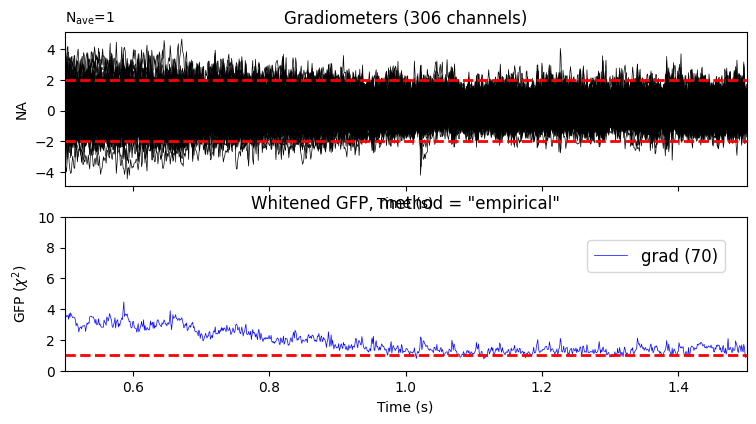

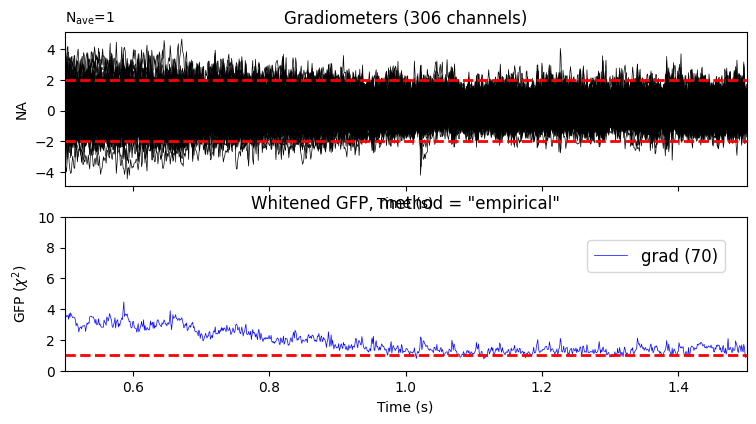

In [24]:
evoked.plot_white(noise_cov, time_unit="s")
#del epochs, raw  # to save memory

In [25]:
import os

directory = "/data/users2/mjafarlou1/results/forwardsolution/sub-01"
filename = "sub-01_task-RDR_run-37_meg_fwd.fif"

filepath = os.path.join(directory, filename)
fwd = mne.read_forward_solution(filepath)


Reading forward solution from /data/users2/mjafarlou1/results/forwardsolution/sub-01/sub-01_task-RDR_run-37_meg_fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8191 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [26]:
fwd.values()

dict_values([2 (FIFFV_MNE_FREE_ORI), 4, 8191, 306, {'nrow': 306, 'ncol': 24573, 'row_names': ['MEG0111', 'MEG0112', 'MEG0113', 'MEG0121', 'MEG0122', 'MEG0123', 'MEG0131', 'MEG0132', 'MEG0133', 'MEG0141', 'MEG0142', 'MEG0143', 'MEG0211', 'MEG0212', 'MEG0213', 'MEG0221', 'MEG0222', 'MEG0223', 'MEG0231', 'MEG0232', 'MEG0233', 'MEG0241', 'MEG0242', 'MEG0243', 'MEG0311', 'MEG0312', 'MEG0313', 'MEG0321', 'MEG0322', 'MEG0323', 'MEG0331', 'MEG0332', 'MEG0333', 'MEG0341', 'MEG0342', 'MEG0343', 'MEG0411', 'MEG0412', 'MEG0413', 'MEG0421', 'MEG0422', 'MEG0423', 'MEG0431', 'MEG0432', 'MEG0433', 'MEG0441', 'MEG0442', 'MEG0443', 'MEG0511', 'MEG0512', 'MEG0513', 'MEG0521', 'MEG0522', 'MEG0523', 'MEG0531', 'MEG0532', 'MEG0533', 'MEG0541', 'MEG0542', 'MEG0543', 'MEG0611', 'MEG0612', 'MEG0613', 'MEG0621', 'MEG0622', 'MEG0623', 'MEG0631', 'MEG0632', 'MEG0633', 'MEG0641', 'MEG0642', 'MEG0643', 'MEG0711', 'MEG0712', 'MEG0713', 'MEG0721', 'MEG0722', 'MEG0723', 'MEG0731', 'MEG0732', 'MEG0733', 'MEG0741', 'MEG

In [27]:
raw_channels = raw.ch_names
forward_channels = fwd['info']['ch_names']


In [28]:
fwd.keys()

dict_keys(['source_ori', 'coord_frame', 'nsource', 'nchan', 'sol', '_orig_sol', 'sol_grad', 'mri_head_t', 'info', 'src', 'source_rr', '_orig_source_ori', 'source_nn', 'surf_ori'])

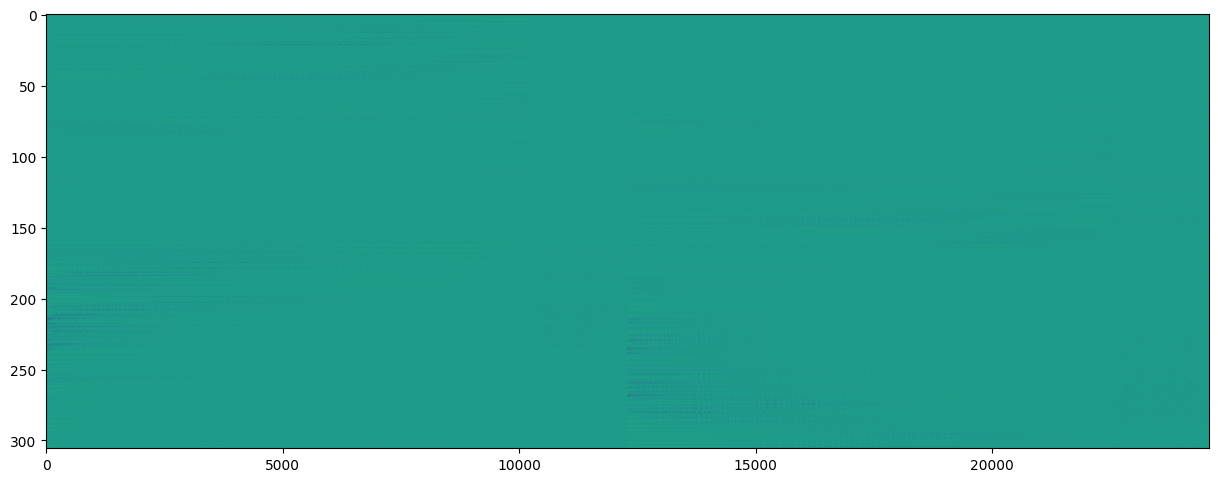

In [29]:
plt.figure(figsize=(15,20))
plt.imshow(fwd['sol']['data'],aspect=30, interpolation=None)

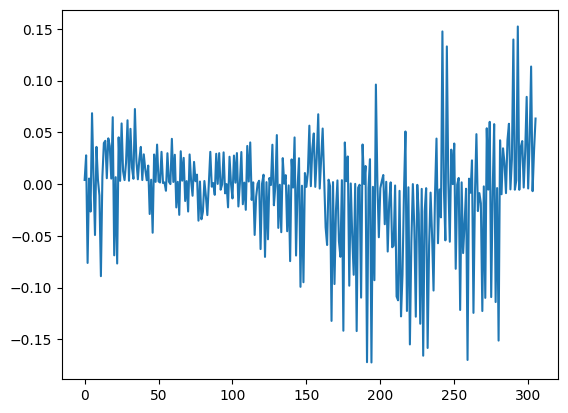

In [30]:
plt.plot(fwd['sol']['data'].sum(axis=1))

In [31]:
fwd['nsource']*3

24573

In [32]:
mne.minimum_norm.make_inverse_operator?

In [33]:
# Assuming you have the necessary imports and dependencies for `make_inverse_operator`
inverse_operator = mne.minimum_norm.make_inverse_operator( # insted of make_inverse_operator
    evoked.info, fwd, noise_cov, loose=0.2, depth=0.8
)
del fwd

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    306 planar channels
    limit = 7756/8191 = 10.018484
    scale = 4.0684e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 9.1e-13 (2.2e-16 eps * 306 dim * 13  max singular value)
    Estimated rank (grad): 70
    GRAD: rank 70 computed from 306 data channels with 0 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.51

In [34]:
fwd.values()

NameError: name 'fwd' is not defined

In [35]:
inverse_operator['eigen_fields']['data']

array([[ 1.38777878e-17,  0.00000000e+00,  1.11022302e-16, ...,
         5.38970729e-02, -1.30279862e-02,  5.91921111e-03],
       [ 2.77555756e-17,  0.00000000e+00, -5.55111512e-17, ...,
        -1.74262148e-01, -4.16005571e-03, -7.48924733e-02],
       [-5.89805982e-17,  2.77555756e-17, -4.16333634e-17, ...,
        -2.17392617e-01,  8.36566701e-02,  8.95588974e-02],
       ...,
       [-3.35625895e-02,  2.03204537e-02, -9.48855665e-03, ...,
        -2.77555756e-17, -2.77555756e-17, -1.04083409e-16],
       [-6.06101990e-01,  1.16809061e-01,  2.65585531e-01, ...,
        -2.35922393e-16,  2.77555756e-17,  1.11022302e-16],
       [-7.72161895e-02, -5.62590079e-02, -3.82393931e-02, ...,
        -4.16333634e-17,  6.93889390e-17,  1.38777878e-17]])

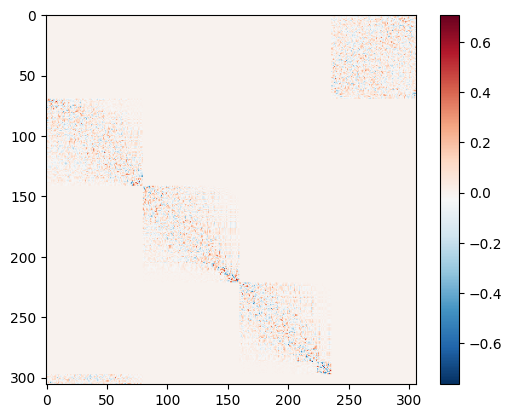

In [36]:
plt.imshow(inverse_operator['eigen_fields']['data'], aspect=1, interpolation=None, cmap=plt.cm.RdBu_r)
plt.colorbar()

In [37]:
mne.minimum_norm.apply_inverse?

In [39]:
method = "dSPM"
snr = 3.0
lambda2 = 1.0 / snr**2

stc, residual = mne.minimum_norm.apply_inverse(
    evoked,
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,
    return_residual=True,
    verbose=True,
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 70 (236 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to ""...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  74.6% variance
    Combining the current components...
    dSPM...
[done]
